# Data Loading From arff files

In [52]:
# !pip install category-encoders
# https://www.kaggle.com/lordozvlad/introduction-to-scikit-learn-intelex

In [53]:
# !pip install sklearn

In [54]:
%time
from scipy.io import arff
import pandas as pd
import urllib.request
from io import StringIO, BytesIO
import copy
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
import numpy as np
import warnings
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('float_format', '{:f}'.format)
warnings.filterwarnings('ignore')
from sklearn.model_selection import StratifiedKFold, cross_val_score
from category_encoders.target_encoder import TargetEncoder

path = 'http://www.ece.uah.edu/~thm0009/icsdatasets/10_water_final.arff'
url = urllib.request.urlopen(path)
data, meta = arff.loadarff(StringIO(url.read().decode('utf-8')))
df = pd.DataFrame(data)
# df.head()

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.48 µs


In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

## Memory Optimizer

In [56]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        if col == 'time':
            df[col] = df[col].astype(np.float32)
            continue
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [57]:
df = reduce_mem_usage(df)

Memory usage of dataframe is 4.98 MB
Memory usage after optimization is: 1.32 MB
Decreased by 73.4%


In [58]:
# df.head()

## Convert Object to int

In [59]:
# make target int type
df['result']= df['result'].replace(b'0',0)
df['result']= df['result'].replace(b'1',1)
df['result']= df['result'].replace(b'2',2)
df['result']= df['result'].replace(b'3',3)
df['result']= df['result'].replace(b'4',4)
df['result']= df['result'].replace(b'5',5)
df['result']= df['result'].replace(b'6',6)
df['result']= df['result'].replace(b'7',7)

In [60]:
df['result'] = df['result'].astype('int64')

In [61]:
len(df.columns)

24

# Features 

In [62]:
# features selection
features = []
for col in df.columns:
    if len(df[col].unique()) != 1 and col != 'result':
        features.append(col)
        # print(len(df[col].unique()), col)

In [63]:
len(features)

18

### Categorical Features

In [64]:
cat_cols = []
for col in features:
    if len(df[col].unique()) < 10:
        cat_cols.append(col)


### Numerical Features

In [65]:
num_cols = [col for col in features
                   if col not in cat_cols]

In [66]:
len(num_cols)

6

In [67]:
df.shape

(27199, 24)

In [68]:
df = df[features+['result']]

In [69]:
df.nunique()

command_address            48
response_address            2
response_memory             2
command_memory_count        2
response_memory_count       2
comm_write_fun              2
resp_write_fun              2
sub_function                2
resp_length                 2
HH                         43
'H'                         5
'L'                        25
LL                        179
control_mode                3
pump                        2
crc_rate                    2
measurement              5267
time                       31
result                      8
dtype: int64

In [70]:
col=df.nunique().sort_values(ascending=False).index[0]

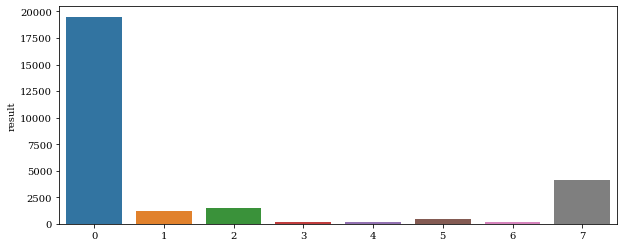

In [71]:
# Check label balance
plt.figure(figsize=(10,4))
sns.barplot(x=df.result.unique(), y=df.result.value_counts())
plt.show()

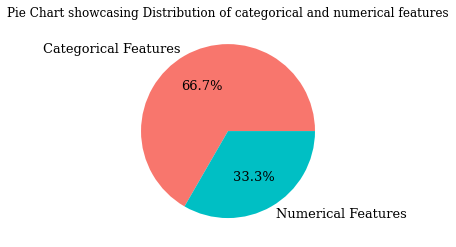

In [72]:
# Categorical and numerical variable distribution
plt.pie([len(cat_cols), len(num_cols)], 
        labels=['Categorical Features', 'Numerical Features'],
        colors=['#F8766D', '#00BFC4'],
        textprops={'fontsize': 13},
        autopct='%1.1f%%')
plt.title('Pie Chart showcasing Distribution of categorical and numerical features')
plt.show()

In [73]:
len(df[col].unique())

5267

In [74]:
# agg_features=df.groupby(['time'])[features].agg(['mean','min','max','sum','median'])

# agg_features.columns=['_'.join(col) for col in agg_features.columns]
# agg_features.reset_index(inplace=True)

In [75]:
# agg_features.nunique()

In [76]:
# df=df.merge(agg_features,on='time')

In [77]:
df.isna().sum()

command_address          0
response_address         0
response_memory          0
command_memory_count     0
response_memory_count    0
comm_write_fun           0
resp_write_fun           0
sub_function             0
resp_length              0
HH                       0
'H'                      0
'L'                      0
LL                       0
control_mode             0
pump                     0
crc_rate                 0
measurement              0
time                     0
result                   0
dtype: int64

In [78]:
# features selection
features = []
for col in df.columns:
    if len(df[col].unique()) != 1 and col != 'result':
        features.append(col)

In [79]:
df['mean'] = df[features].mean(axis=1)
df['median'] = df[features].mean(axis=1)
df['max'] = df[features].max(axis=1)
df['min'] = df[features].min(axis=1)
features.extend(['mean','median','max', 'min'])

In [80]:
df.head()

,command_address,response_address,response_memory,command_memory_count,response_memory_count,comm_write_fun,resp_write_fun,sub_function,resp_length,HH,'H','L',LL,control_mode,pump,crc_rate,measurement,time,result,mean,median,max,min
0,7.000000,7.000000,233.000000,9.000000,10.000000,10.000000,10.000000,0.000000,21.000000,90.000000,80.000000,20.000000,10.000000,2.000000,0.000000,1.000000,85.758957,1.000000,0,33.153275,33.153275,233.000000,0.000000
1,7.000000,7.000000,233.000000,9.000000,10.000000,10.000000,10.000000,0.000000,21.000000,90.000000,80.000000,20.000000,10.000000,2.000000,0.000000,1.000000,85.673676,1.070000,0,33.152428,33.152428,233.000000,0.000000
2,7.000000,7.000000,233.000000,9.000000,10.000000,10.000000,10.000000,0.000000,21.000000,90.000000,80.000000,20.000000,10.000000,2.000000,0.000000,1.000000,85.616829,1.160000,0,33.154266,33.154266,233.000000,0.000000
3,7.000000,7.000000,233.000000,9.000000,10.000000,10.000000,10.000000,0.000000,21.000000,90.000000,80.000000,20.000000,10.000000,2.000000,0.000000,1.000000,85.559975,1.100000,0,33.147778,33.147778,233.000000,0.000000
4,7.000000,7.000000,233.000000,9.000000,10.000000,10.000000,10.000000,0.000000,21.000000,90.000000,80.000000,20.000000,10.000000,2.000000,0.000000,1.000000,85.474701,1.150000,0,33.145821,33.145821,233.000000,0.000000


In [81]:
cat_cols = []
for col in features:
    if len(df[col].unique()) < 10:
        cat_cols.append(col)
    # print(col)

In [82]:
num_cols = [col for col in features
                   if col not in cat_cols]

## Label Encoder

In [83]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder() 

In [84]:
for col in cat_cols:
    df.loc[:, col] = le.fit_transform(df[col].values)

In [85]:
# optional
for col in features:
    df[col] = df[col] + 1

## Correlation

In [86]:
mat = df[features + ['result']].corr()

In [87]:
imp_cols = []
for val, col in enumerate(mat.result):
    if ((col >= 0.1 or col <= -0.1) and val != len(mat.result)-1):
        # imp_cols.append(val)
        print(features[val])
        imp_cols.append(features[val])

response_address
response_memory
command_memory_count
response_memory_count
comm_write_fun
resp_write_fun
sub_function
resp_length
HH
'H'
control_mode
crc_rate
time


In [88]:
# from sklearn.preprocessing import SplineTransformer
# spline = SplineTransformer(degree=2, n_knots=3)
# X = spline.fit_transform(df[num_cols])

In [89]:
# X = pd.DataFrame(X)

In [90]:
# X.head()

## Target Encoding

## Stratified K-Fold

In [91]:
# from pycaret.classification import *

In [92]:
# clf1 = setup(data = df, 
#              target = 'result',
#             use_gpu=True)

In [93]:
# best = compare_models()

# Models

In [94]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm import LGBMClassifier as lgbm
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier

In [95]:
def eval_acc(model, x, y):
    cv = StratifiedKFold(n_splits = 5, shuffle=True, random_state = 42)
    scores = cross_val_score(model, x, y, scoring='roc_auc_ovo', cv=cv, n_jobs=-1)
    return scores

In [96]:
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
cb = CatBoostClassifier()
xg = XGBClassifier()
# .RandomForestClassifier(n_estimators=100, *, criterion='gini', 
# max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
# max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, 
# random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)
rf = RandomForestClassifier()
adb = AdaBoostClassifier()
# nb = GaussianNB()
# qda = QuadraticDiscriminantAnalysis()
et = ExtraTreesClassifier()
lg = lgbm()
# mlb = MultinomialNB()
# mlp = MLPClassifier()
# svm = SVC()
# rbf = RBF()

In [97]:
# models = [knn, dt, rf, adb, nb, qda, et, mlp, svm]
# models = [knn, dt, adb, et, lg, rf]
models = [et, lg, rf]
# models = [cb, xg, rf]

In [98]:
x = df[features]
y = df.result

In [99]:
w0, w1, w2 =1,1,1

In [100]:
import gc
estimator_list = np.arange(100, 1500, 100)
seeds = [69420, 42, 69, 666]
scores = pd.DataFrame()

In [101]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size=0.2, random_state=42)

In [102]:
w = []
for m in models:
    z = np.mean(eval_acc(m, xtrain, ytrain))
    print(str(m) + '\t\t' + str(z))
    w.append(z)

ExtraTreesClassifier()		0.9893429500408247
LGBMClassifier()		0.9970106195482445
RandomForestClassifier()		0.9927427638607783


In [103]:
if w[0] > w[1] and w[0] > w[2]:
    w0 = 3
    if w[1] > w[2]:
        w1 = 2
        w2 = 1
    else:
        w2 = 2
        w1 = 1
    print('yes1')
elif w[1] > w[0] and w[1] > w[2]:
    w1 = 3
    if w[0] > w[2]:
        w0 = 2
        w2 = 1
    else:
        w2 = 2
        w0 = 1
    print('yes2')
elif w[2] > w[1] and w[2] > w[0]:
    w2 = 3
    if w[1] > w[0]:
        w1 = 2
        w0 = 1
    else:
        w0 = 2
        w1 = 1
    print('yes3')

yes2


In [104]:
print(w0, w1, w2)

1 3 2


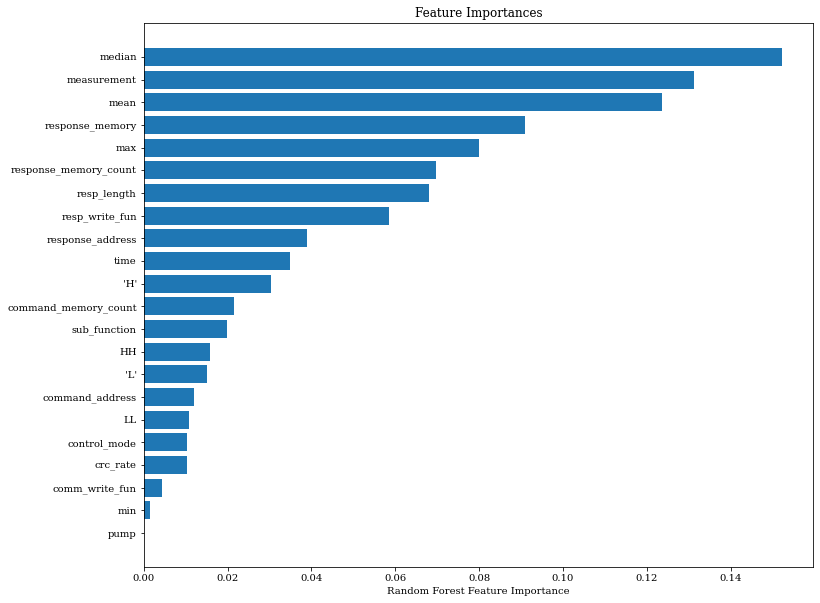

In [105]:
rf.fit(xtrain, ytrain)
importances = rf.feature_importances_
plt.figure(figsize=(12,10))
idxs = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(idxs)), importances[idxs], align='center')
plt.yticks(range(len(idxs)), [features[i] for i in idxs])
plt.xlabel('Random Forest Feature Importance')
plt.show()

In [106]:
imp = []
for i in idxs:
    if importances[i] != 0:
        imp.append([importances[i], features[i]])
imp.sort(reverse=True)
s1 = imp

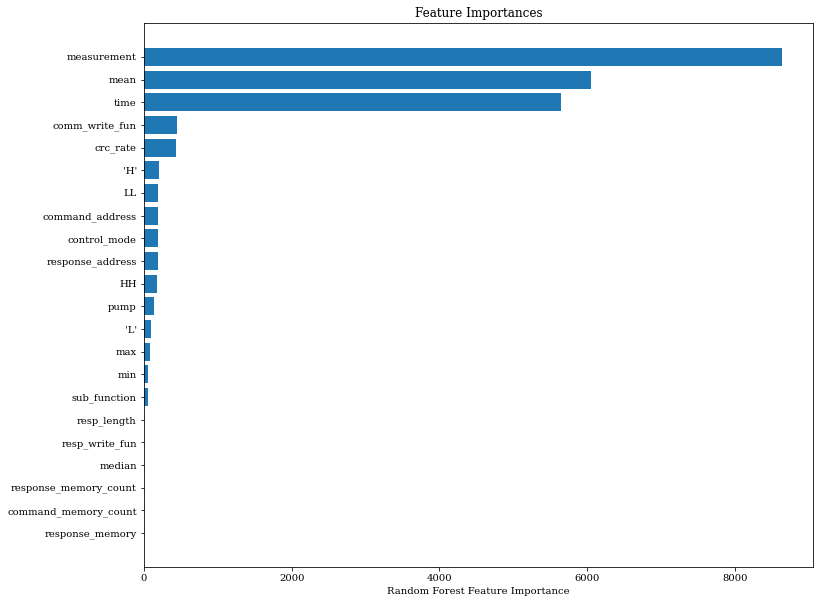

In [107]:
lg.fit(xtrain, ytrain)
importances = lg.feature_importances_
plt.figure(figsize=(12,10))
idxs = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(idxs)), importances[idxs], align='center')
plt.yticks(range(len(idxs)), [features[i] for i in idxs])
plt.xlabel('Random Forest Feature Importance')
plt.show()

In [108]:
imp = []
for i in idxs:
    if importances[i] != 0:
        imp.append([importances[i], features[i]])
imp.sort(reverse=True)
s2 = imp

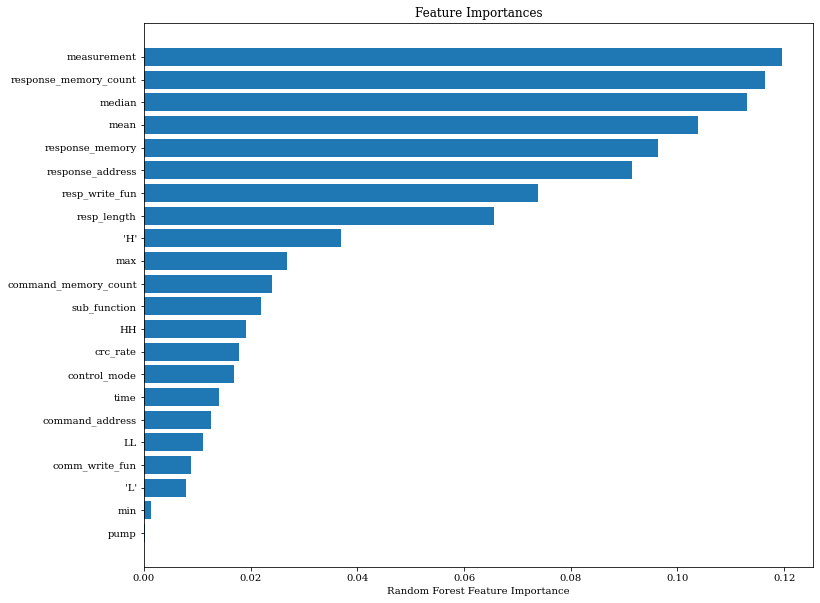

In [109]:
et.fit(xtrain, ytrain)
importances = et.feature_importances_
plt.figure(figsize=(12,10))
idxs = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(idxs)), importances[idxs], align='center')
plt.yticks(range(len(idxs)), [features[i] for i in idxs])
plt.xlabel('Random Forest Feature Importance')
plt.show()

In [110]:
imp = []
for i in idxs:
    if importances[i] != 0:
        imp.append([importances[i], features[i]])
imp.sort(reverse=True)
s3 = imp

In [111]:
d1 = pd.DataFrame(s1)
d2 = pd.DataFrame(s2)
d3 = pd.DataFrame(s3)

In [112]:
s1 = set(d1[1])
s2 = set(d2[1])
s3 = set(d3[1])

In [113]:
# s1

In [114]:
# s1 = set(s1)
# s2 = set(s2)
# s3 = set(s3)
col_imp = s1.intersection(s2,s3)
print(col_imp)

{'crc_rate', 'comm_write_fun', "'H'", 'response_address', 'pump', 'measurement', 'LL', "'L'", 'HH', 'mean', 'time', 'control_mode', 'min', 'sub_function', 'command_address', 'resp_length', 'max'}


In [115]:
len(col_imp)

17

In [116]:
# xtrain = xtrain[col_imp]
# xtest = xtest[col_imp]

In [130]:
eclf = VotingClassifier(estimators=[('et', et), ('lg', lg), ('rf', rf)], voting='soft', weights=[w0, w1, w2])
# eclf = VotingClassifier(estimators=[('cb', cb), ('xg', xg), ('rf', rf)], voting='soft', weights=[w0, w1, w2])

In [131]:
xtrain.shape

(21759, 22)

In [132]:
from sklearn.metrics import classification_report
# from sklearn.feature_selection import chi2, f_classif
# from sklearn.feature_selection import SelectKBest

In [133]:
eclf.fit(xtrain,ytrain)

VotingClassifier(estimators=[('et', ExtraTreesClassifier()),
                             ('lg', LGBMClassifier()),
                             ('rf', RandomForestClassifier())],
                 voting='soft', weights=[1, 3, 2])

In [134]:
ypred = eclf.predict(xtest)

In [135]:
print(classification_report(ytest, ypred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      3897
           1       0.98      0.97      0.97       234
           2       0.70      0.77      0.73       298
           3       0.97      1.00      0.99        38
           4       1.00      0.99      0.99        82
           5       1.00      1.00      1.00        25
           6       1.00      0.94      0.97        31
           7       1.00      1.00      1.00       835

    accuracy                           0.97      5440
   macro avg       0.95      0.95      0.95      5440
weighted avg       0.97      0.97      0.97      5440



In [136]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [137]:
print(accuracy_score(ytest, ypred))

0.9661764705882353


In [138]:
print(roc_auc_score(ytest, eclf.predict_proba(xtest),multi_class='ovo'))

0.9977564915429701


In [139]:
print(roc_auc_score(ytest, rf.predict_proba(xtest),multi_class='ovo'))
print(roc_auc_score(ytest, lg.predict_proba(xtest),multi_class='ovo'))
print(roc_auc_score(ytest, et.predict_proba(xtest),multi_class='ovo'))

0.9943706478236508
0.997426017979934
0.9905405048205393


In [140]:
print(accuracy_score(ytest, rf.predict(xtest)))
print(accuracy_score(ytest, lg.predict(xtest)))
print(accuracy_score(ytest, et.predict(xtest)))

0.9693014705882353
0.9636029411764706
0.9630514705882353


In [141]:
len(cat_cols)

12

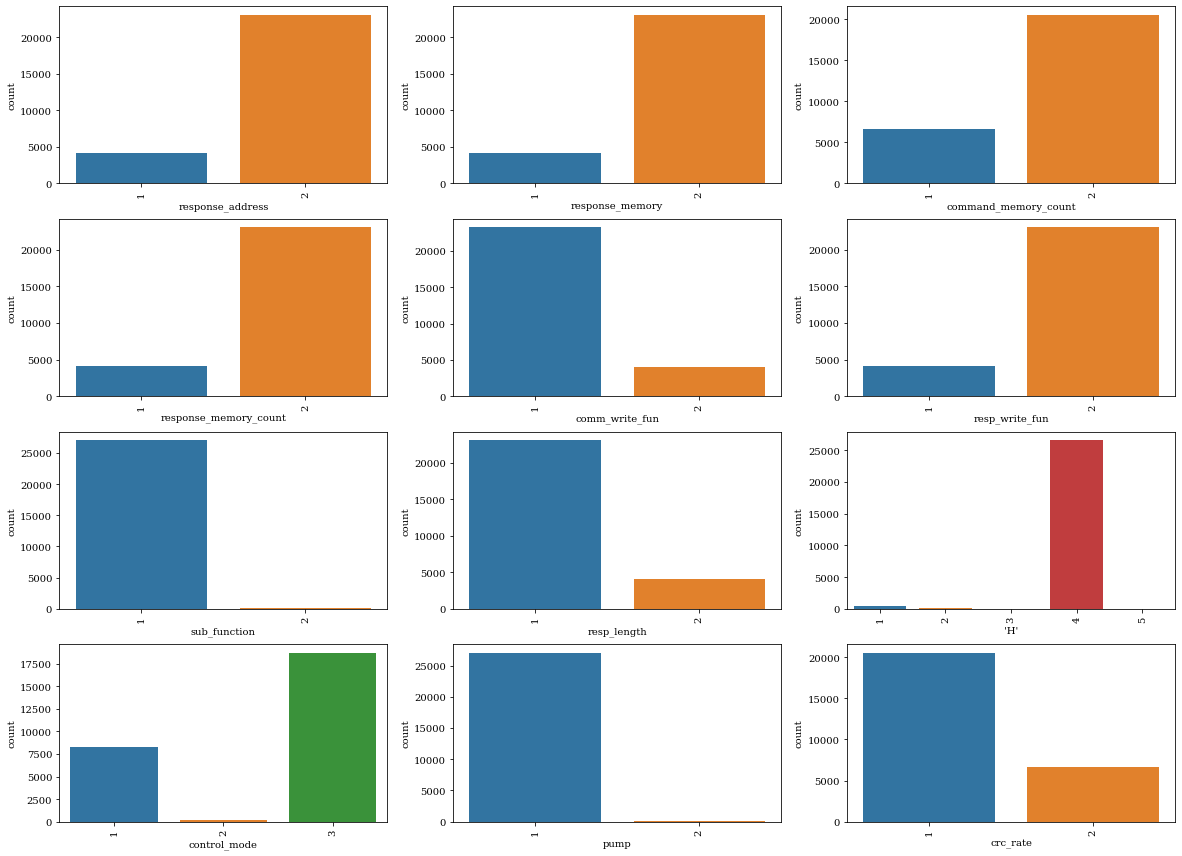

In [142]:
fig = plt.figure(figsize=(20,15))
i = 1
for col in cat_cols:
    plt.subplot(4,3,i)
    sns.countplot(df[col])
    plt.xticks(rotation=90)
    i += 1
# fig.show()

plt.savefig('catplots.png')